In [ ]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-

# Playing BlackJack with First Visit MC

<p style="color:blue;">
By Pramod Sharma : pramod.sharma@prasami.com<br>
&#169; 2020 Prasami Technologies
<p>

In [1]:
# import statements

import gym
import numpy as np
from matplotlib import pyplot
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from collections import defaultdict
from functools import partial
%matplotlib inline
plt.style.use('ggplot')

In [2]:
# Some basic parameters
inpDir = '../input'
outDir = '../output'

RANDOM_STATE = 24
STEPS = 200

# parameters for Matplotlib
params = {'legend.fontsize': 'x-large',
          'figure.figsize': (9, 6),
          'axes.labelsize': 'x-large',
          'axes.titlesize':'x-large',
          'xtick.labelsize':'x-large',
          'ytick.labelsize':'x-large'
         }

plt.rcParams.update(params)


 Simulate the Blackjack environment

In [3]:
env = gym.make('Blackjack-v0')

Then we define the policy function which takes the current state and check if the score is
greater than or equal to 20, if yes we return 0 else we return 1. i.e If the score is greater
than or equal to 20 we stand (0) else we hit (1)

In [4]:
def sample_policy(observation):
    score, dealer_score, usable_ace = observation
    return 0 if score >= 20 else 1

We define a function called generate_episode for generating epsiodes

In [24]:
def generate_episode(policy, env):
    
    # we initialize the list for storing states, actions, and rewards
    states, actions, rewards = [], [], []
    
    # Initialize the gym environment
    observation = env.reset() #observation is a tuple of player cards, dealer cards, is usable ace
    
    while True:
        
        # append the states to the states list
        states.append(observation)
        
        # now, we select an action using our sample_policy function and append the action to actions list
        action = sample_policy(observation)
        actions.append(action)
        
        # We perform the action in the environment according to our sample_policy, move to the next state 
        # and receive reward
        #print(observation)
        observation, reward, done, info = env.step(action)
        rewards.append(reward)
        
        # Break if the state is a terminal state
        if done:
             break
                
    return states, actions, rewards

 Now that we learned how to generate an episode, we will see how to perform First Vist MC Prediction

In [25]:
def first_visit_mc_prediction(policy, env, n_episodes):
    
    # First, we initialize the empty value table as a dictionary for storing the values of each state
    value_table = defaultdict(float)
    N = defaultdict(int)

    
    for _ in range(n_episodes):
        
        # Next, we generate the epsiode and store the states and rewards
        states, _, rewards = generate_episode(policy, env)
        returns = 0
        
        # Then for each step, we store the rewards to a variable R and states to S, and we calculate
        # returns as a sum of rewards
        
        for t in range(len(states) - 1, -1, -1):
            R = rewards[t]
            S = states[t]
            
            returns += R
            
            # Now to perform first visit MC, we check if the episode is visited for the first time, if yes,
            # we simply take the average of returns and assign the value of the state as an average of returns
            
            if S not in states[:t]: #not considering repeated states
                N[S] += 1
                value_table[S] += (returns - value_table[S]) / N[S] # for a particular state rewards of all possible episodes from 
                                                                    # thatt state is averaged and updated 
    
    return value_table

In [26]:
value = first_visit_mc_prediction(sample_policy, env, n_episodes=50000)

Let us see first few elements in the value table

In [17]:
for i in range(10):
    print(value.popitem())

((4, 6, False), -0.7222222222222221)
((4, 4, False), -0.25)
((12, 1, True), -0.5416666666666666)
((7, 1, False), -0.6777777777777775)
((4, 8, False), -0.7500000000000001)
((4, 2, False), -0.43999999999999995)
((4, 5, False), -0.3103448275862069)
((12, 4, True), -0.3157894736842105)
((5, 4, False), -0.34090909090909083)
((6, 5, False), -0.4545454545454546)


 We define the function plot_blackjack for plotting the value function and we can see how our value function is attaining the convergence. 

In [18]:
def plot_blackjack(V, ax1, ax2):
    player_sum = np.arange(12, 21 + 1)
    dealer_show = np.arange(1, 10 + 1)
    usable_ace = np.array([False, True])
    state_values = np.zeros((len(player_sum), len(dealer_show), len(usable_ace)))

    for i, player in enumerate(player_sum):
        for j, dealer in enumerate(dealer_show):
            for k, ace in enumerate(usable_ace):
                state_values[i, j, k] = V[player, dealer, ace]
    
    X, Y = np.meshgrid(player_sum, dealer_show)
 
    ax1.plot_wireframe(X, Y, state_values[:, :, 0])
    ax2.plot_wireframe(X, Y, state_values[:, :, 1])
 
    for ax in ax1, ax2:
        ax.set_zlim(-1, 1)
        ax.set_ylabel('player sum')
        ax.set_xlabel('dealer showing')
        ax.set_zlabel('state-value')
        

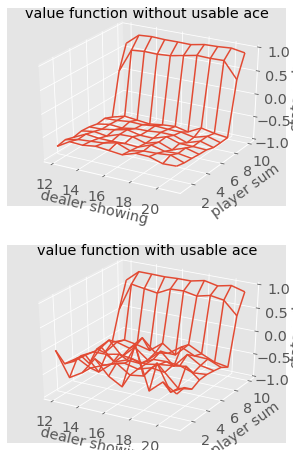

In [19]:
fig, axes = pyplot.subplots(nrows=2, figsize=(5, 8),
subplot_kw={'projection': '3d'})
axes[0].set_title('value function without usable ace')
axes[1].set_title('value function with usable ace')
plot_blackjack(value, axes[0], axes[1])